# Eight schools - hierarchical modelling with HMC

In [87]:
import numpy as np
import jax
import jax.numpy as jnp
import jax.scipy.stats as stats

from gaul import hmc

import matplotlib.pyplot as plt
import seaborn as sns
import pears

plt.rcParams['figure.figsize'] = (11, 7)

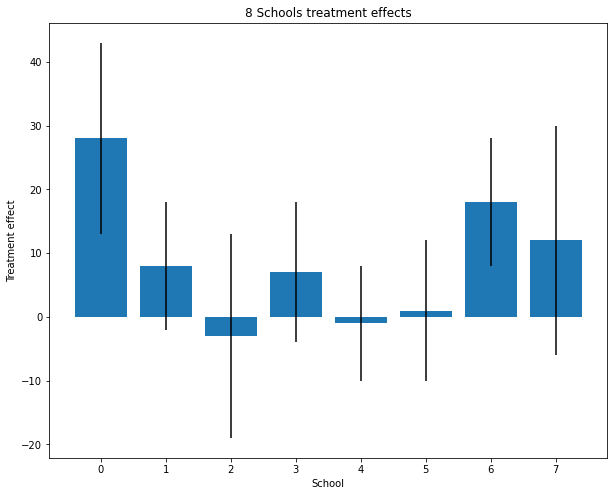

In [2]:
num_schools = 8 
treatment_effects = jnp.array(
    [28., 8, -3, 7, -1, 1, 18, 12], 
)
treatment_stddevs = jnp.array(
    [15., 10, 16, 11, 9, 11, 10, 18],
)

fig, ax = plt.subplots()
plt.bar(range(num_schools), treatment_effects, yerr=treatment_stddevs)
plt.title("8 Schools treatment effects")
plt.xlabel("School")
plt.ylabel("Treatment effect")
fig.set_size_inches(10, 8)
plt.show()

In [3]:
params = dict(
    mu=jnp.zeros(1),
    logtau=jnp.zeros(1),
    theta_prime=jnp.zeros(8),
)

data = dict(
    treatment_effect=treatment_effects,
    treatment_std=treatment_stddevs,
)

In [4]:
def ln_posterior(params, data):
    target = 0.
    
    target += stats.norm.logpdf(params['mu'], 0., 10.)
    target += stats.norm.logpdf(params['logtau'], 5., 1.)
    target += stats.norm.logpdf(params['theta_prime']).sum()
    
    theta_i = params['mu'] + jnp.exp(params['logtau']) * params['theta_prime']
    target += stats.norm.logpdf(data['treatment_effect'], loc=theta_i, scale=data['treatment_std']).sum()
    
    return target.sum()

In [81]:
samples = hmc.sample(
    ln_posterior, 
    params, 
    n_chains=10,
    n_samples=1000,
    n_warmup=3000,
    step_size=0.2,
    leapfrog_steps=5,
    data=data
)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [82]:
school_effect_samples = samples['mu'] + jnp.exp(samples['logtau']) * samples['theta_prime']

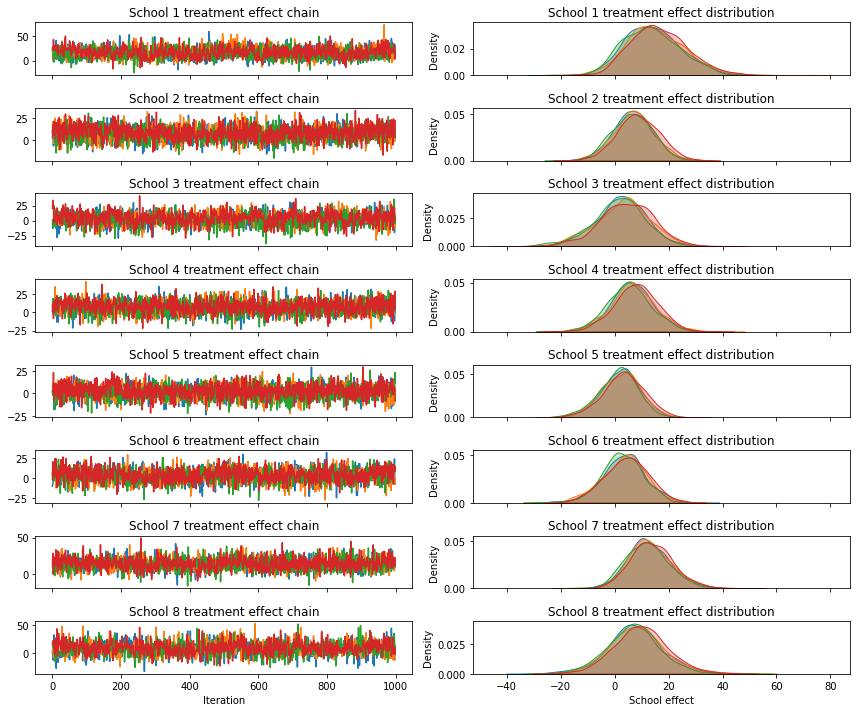

In [86]:
fig, axes = plt.subplots(8, 2, sharex='col')
fig.set_size_inches(12, 10)
for i in range(num_schools):
    for j in range(4):
        axes[i][0].plot(school_effect_samples[j,i])
        axes[i][0].title.set_text(f"School {i+1} treatment effect chain")
        sns.kdeplot(school_effect_samples[j,i], ax=axes[i][1], shade=True)
        axes[i][1].title.set_text(f"School {i+1} treatment effect distribution")
axes[num_schools - 1][0].set_xlabel("Iteration")
axes[num_schools - 1][1].set_xlabel("School effect")
fig.tight_layout()

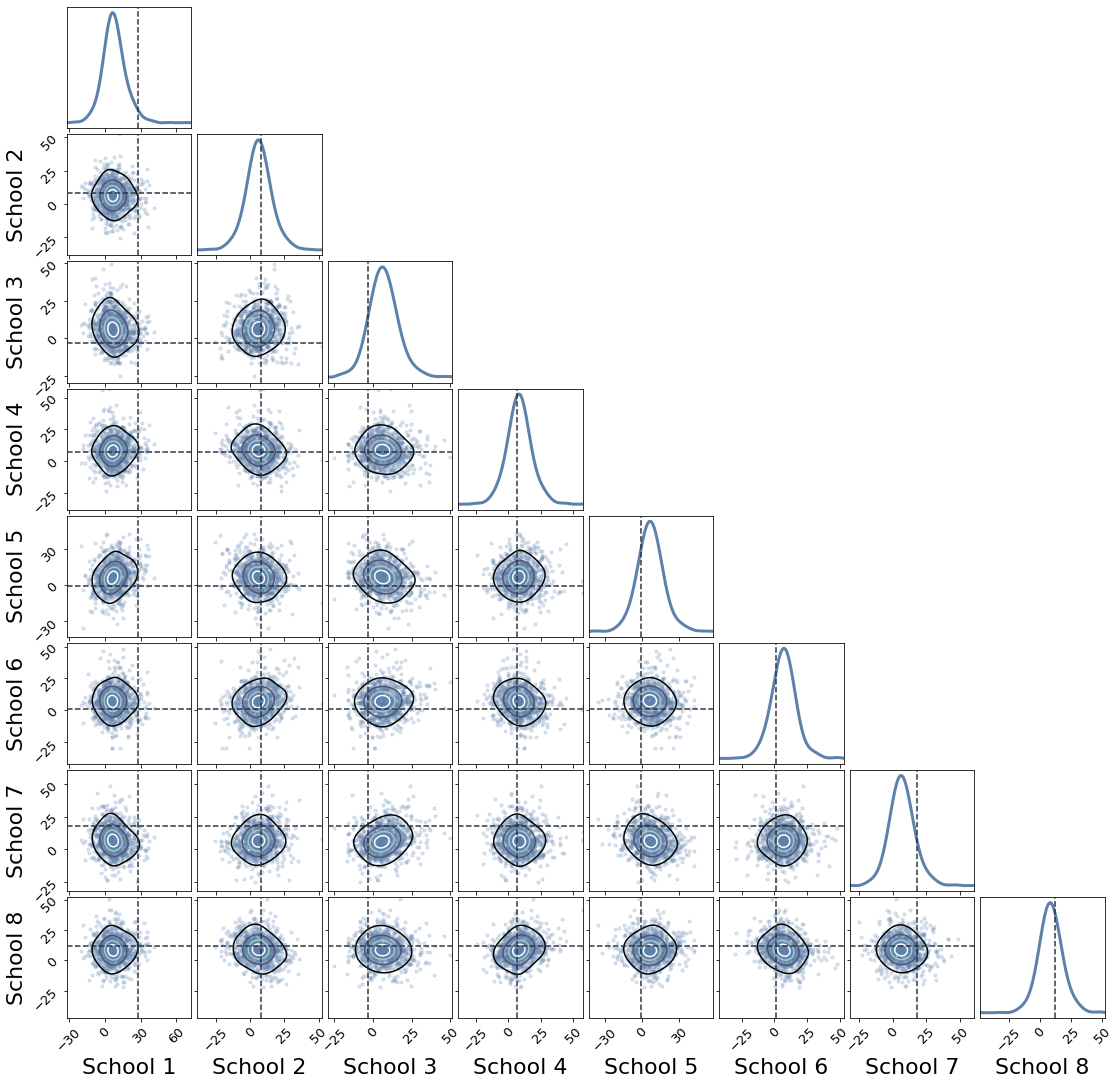

In [85]:
pears.pears(
    school_effect_samples.reshape(8, -1),
    truths=treatment_effects,
    labels=[f'School {i+1}' for i in range(8)],
    scatter_thin=10,
);